In [1]:
!pip install trackpy >/dev/null
!pip install nplocate >/dev/null
import numpy as np
import trackpy as tp
import nplocate as nl
import matplotlib.pyplot as plt

# How to use nplocate


This notebook is a practical guide on using `nplocate` to deal with "difficult" confocal images


## Load the image

The image is from highly distorted along the z-axis

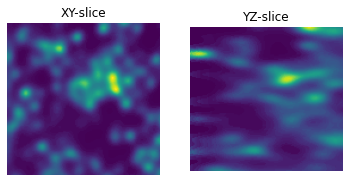

In [2]:
img = np.load('image.npy')
plt.subplot(121).imshow(img[:, :, 50].T)
plt.title('XY-slice')
plt.axis('off')
plt.subplot(122).imshow(img[50])
plt.title('YZ-slice')
plt.axis('off')
plt.show()

## Get initial estimation of particle positions

Now let us use the very well written particle tracking package [trackpy](https://github.com/soft-matter/trackpy) to find some initial locations of the particles.

We need to give `trackpy` an estimation of the particle diameter.

In `nplocate` there is a nice tool called `see_slice` that allows one the examine the tracking results. The output image is an *exact* representation if there were spherical particles in a particle 2D slice.

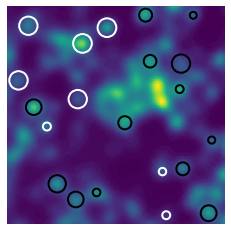

In [3]:
diameter = 11
xyz = tp.locate(img, diameter=diameter)
xyz = np.array(xyz)[:, :3]
xyz_tp = xyz.copy()  # store the result to compare with the refined results

nl.see_slice(img, xyz, s=50, radius=5.5, axis=2, sizes=(4, 4))

## Find more particles

in the function `add`, `nplocate` measures the average shape of the particles and try to find extra particles in the difference between origional image and the simulated image.

The function `add` needs a quite special parameter, `locate_func`. This is a function, that returns the X-Y-Z coordinates given the image. It should work like this,

```py
positions = locate_func(image)
```

It is very convinent to wrap your current tracking scheme with a `lambda` expression like the following example

In addition, the `threshold` parameter will remove all extera particles whose intensity is below this value. This significantly affect the final result and you absolutly want to play a lot and choose a sensible value. (Setting it to zero, you can get a lot of particles.)

In [4]:
should_add = True
r_model = 2 * diameter
iter_num = 0
while should_add:
    n0 = xyz.shape[0]
    xyz = nl.add(
        positions=xyz,
        image=img,
        r_model=r_model,
        diameter=diameter,
        locate_func=lambda im : np.array(tp.locate(im, diameter))[:, :3],
        threshold=20
    )
    n1 = xyz.shape[0]
    should_add = n1 > n0
    iter_num += 1
    print('#{}, {} -> {}'.format(iter_num, n0, n1))
   

#1, 190 -> 263
#2, 263 -> 277
#3, 277 -> 280
#4, 280 -> 280


It looks good, we end up with 280 particles, comparing with the 190 particles that were began with

## Refine the positions

As a bonus, we can actually minimize the difference between our simulated image and the real image. This process is actually quite fast if we can calculate the Jacobian matrix of the cost function. And yes we can!

Now it's use the function `refine` to finally refine our particle positions.

The final step of `refine` will remove all overlapping particles and only leave the brighter ones. So the number of particles might be slightly decreased. 

In [5]:
xyz = nl.refine(xyz, img, r_model, diameter)
xyz.shape, xyz_tp.shape

((263, 3), (190, 3))

## Check the result

Let's first see the tracking result visually. Look at those extra particles.

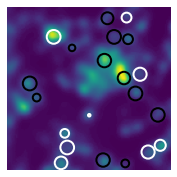

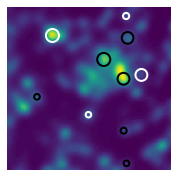

In [6]:
s = 40
axis = 2

nl.see_slice(img, xyz, s, 5.5, axis, sizes=(3, 3))
nl.see_slice(img, xyz_tp, s, 5.5, axis, sizes=(3, 3))

`nplocate` also offered a handy function `get_gr` to calculate the radial distribution function of the particle locations.

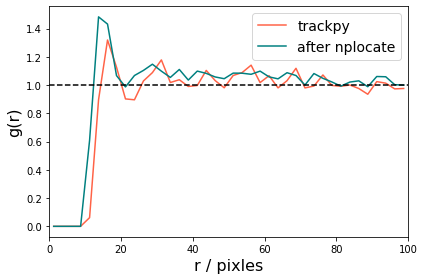

In [7]:
plt.plot(*nl.get_gr(xyz_tp, 100, 41), label="trackpy", color='tomato')
plt.plot(*nl.get_gr(xyz, 100, 41), label="after nplocate", color='teal')
plt.plot((0, 100), (1, 1), color='k', ls='--')
plt.legend(fontsize=14)
plt.xlabel('r / pixles', fontsize=16)
plt.ylabel('g(r)', fontsize=16)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

Frankly I can't tell which result is closer to the truth. Try a lot, choose sensible parameters and good luck!